# **Ahmet Selçuk KÜREN Staj Çalışmaları**
## **KNN (K-Nearest Neighbors) Algoritması Nedir?**
Makine öğrenmesi ile çözülebilen problemlerden biri çok geniş kullanım alanı ile sınıflandırma problemleridir. Günümüzdeki bir çok problem bir şekilde sınıflandırma problemi olarak tasarlanıp çözülebilmektdir.

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
df = pd.read_csv("diabetes.csv")

df.head()
df.shape
df.describe().T
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Data Preprocessing & Feature Engineering

In [3]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_scaled = StandardScaler().fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)

Modeling & Prediction

In [4]:
knn_model = KNeighborsClassifier().fit(X, y)

random_user = X.sample(1, random_state=45)

knn_model.predict(random_user)

array([1])

Model Evaluation

In [5]:
# Confusion matrix için y_pred:
y_pred = knn_model.predict(X)

# AUC için y_prob:
y_prob = knn_model.predict_proba(X)[:, 1]

print(classification_report(y, y_pred))
# acc 0.83
# f1 0.74
# AUC
roc_auc_score(y, y_prob)
# 0.90

cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.79      0.70      0.74       268

    accuracy                           0.83       768
   macro avg       0.82      0.80      0.81       768
weighted avg       0.83      0.83      0.83       768



0.7805279524807827

In [6]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Hyperparameter Optimization

In [7]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

knn_params = {"n_neighbors": range(2, 50)}

knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X, y)

knn_gs_best.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 17}

Final Model

In [8]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

random_user = X.sample(1)

knn_final.predict(random_user)

array([0])

**Karar Ağaçları**

Karar ağaçları, Sınıflandırma ve Regresyon problemlerinde kullanılan, ağaç tabanlı algoritmadan biridir. Karmaşık veri setlerinde kullanılabilir.

In [10]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv("diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

Random Forests

Fitting 5 folds for each of 180 candidates, totalling 900 fits


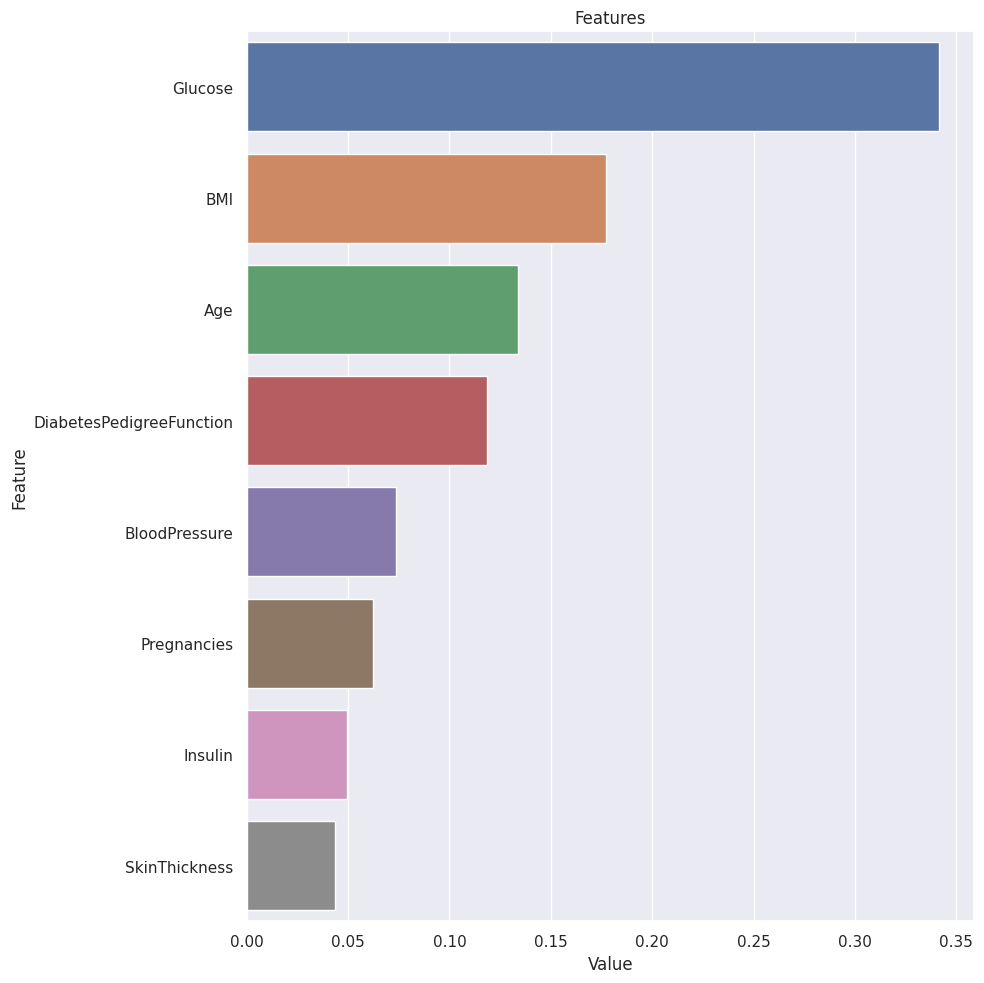

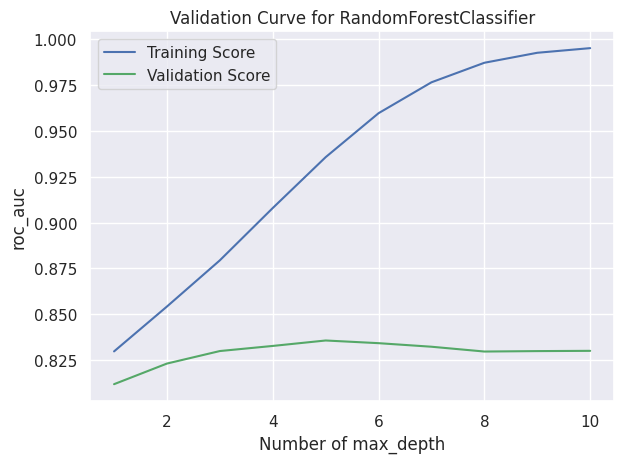

In [12]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

model derlemesi yaklaşık 11 dakika sürmektedir.